# Lepton $\Delta R$ vs signal parameters

## Gen-level study
I want to understand how gen-level dR(e,e) and dR(mu,mu) vary with bound state and dark photon mass. I will also check the assumption that these gen-level quantities are independent of dark photon decay length.

In [1]:
# python
import sys
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoAODSchema
import awkward as ak
from dask.distributed import Client, performance_report
# local
sidm_path = str(sys.path[0]).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import utilities, sidm_processor, scaleout
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline

In [2]:
client = scaleout.make_dask_client("tls://localhost:8786")
client

Connection method: Direct,
Dashboard: /user/bryan.cardwell@cern.ch/proxy/8787/status,
Comm: tls://192.168.202.33:8786,Workers: 0
Dashboard: /user/bryan.cardwell@cern.ch/proxy/8787/status,Total threads: 0
Started: 14 hours ago,Total memory: 0 B


### Take a first look and verify dark photon ctau is irrelevant
Start by plotting gen-level dR for the edge case signal points (largest and smallest bound state masses, dark photon masses, and dark photon decay lengths).

In [3]:
edge_samples = [
    "2Mu2E_100GeV_0p25GeV_0p02mm",
    "2Mu2E_100GeV_0p25GeV_20p0mm",
    "2Mu2E_100GeV_5p0GeV_0p4mm",
    "2Mu2E_100GeV_5p0GeV_400mm",
    "2Mu2E_1000GeV_0p25GeV_0p002mm",
    "2Mu2E_1000GeV_0p25GeV_2p0mm",
    "2Mu2E_1000GeV_5p0GeV_0p04mm",
    "2Mu2E_1000GeV_5p0GeV_40p0mm",
]
edge_fileset = utilities.make_fileset(edge_samples, "llpNanoAOD_v2", max_files=-1, location_cfg="signal_2mu2e_v10.yaml")

runner = processor.Runner(
    #executor=processor.IterativeExecutor(),
    executor=processor.DaskExecutor(client=client),
    schema=NanoAODSchema,
    #maxchunks=1,
    skipbadfiles=True,
)

channels = ["baseNoLj"]
p = sidm_processor.SidmProcessor(
    channels,
    ["genE_base", "genMu_base"],
)

output = runner.run(edge_fileset, treename="Events", processor_instance=p)
out = output["out"]

/opt/conda/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.0. Please consider upgrading.
  warnings.warn(


In [4]:
def plot_all_samples(samples, hist):
    for sample in samples:
        utilities.plot(out[sample]["hists"][hist][channels[0], :], density=True)
    plt.legend([s[6:] for s in samples])

First apply cut to select only gen electrons and muons whose distinct parent is a dark photon and look at the number of gen electrons and muons in each event.

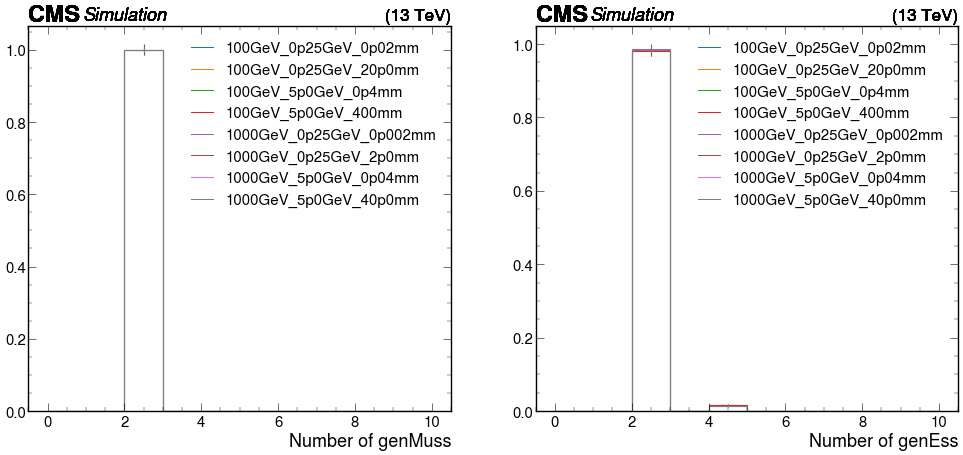

In [5]:
plt.subplots(1, 2, figsize=(24, 10))
plt.subplot(1, 2, 1)
plot_all_samples(edge_samples, "genMu_n")
plt.subplot(1, 2, 2)
plot_all_samples(edge_samples, "genE_n")

Oh weird, there are events with more than 2 gen electrons. These can't be from muon decays because then the distinctParent would be a muon. Maybe they're from an electron bremming off a photon that then converts? I would have thought the distinctParent would be a photon in that case though... Either way, plot the parents (as opposed to distinctParents) of these gen e and mu to see if that helps understand anything.

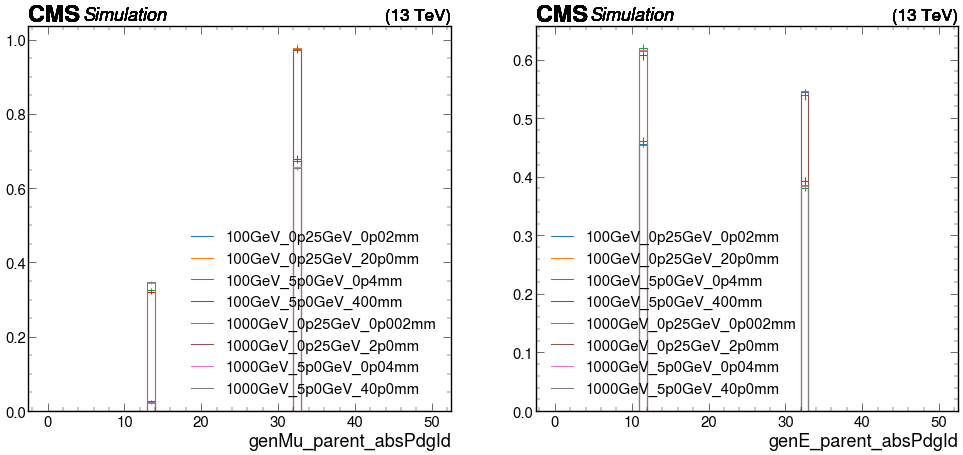

In [6]:
plt.subplots(1, 2, figsize=(24, 10))
plt.subplot(1, 2, 1)
plot_all_samples(edge_samples, "genMu_parent_absPdgId")
plt.subplot(1, 2, 2)
plot_all_samples(edge_samples, "genE_parent_absPdgId")

All gen e (mu) come directly from gen e (mu) or dark photons, which is what I would expect in general but doesn't explain how I have some 2mu2e events w/ >2 gen e whose distinctParent is a dark photon. I suppose I will set this mystery aside for now and move on. Next compare the dR(l,l) distributions for very prompt and very displaced signal points.

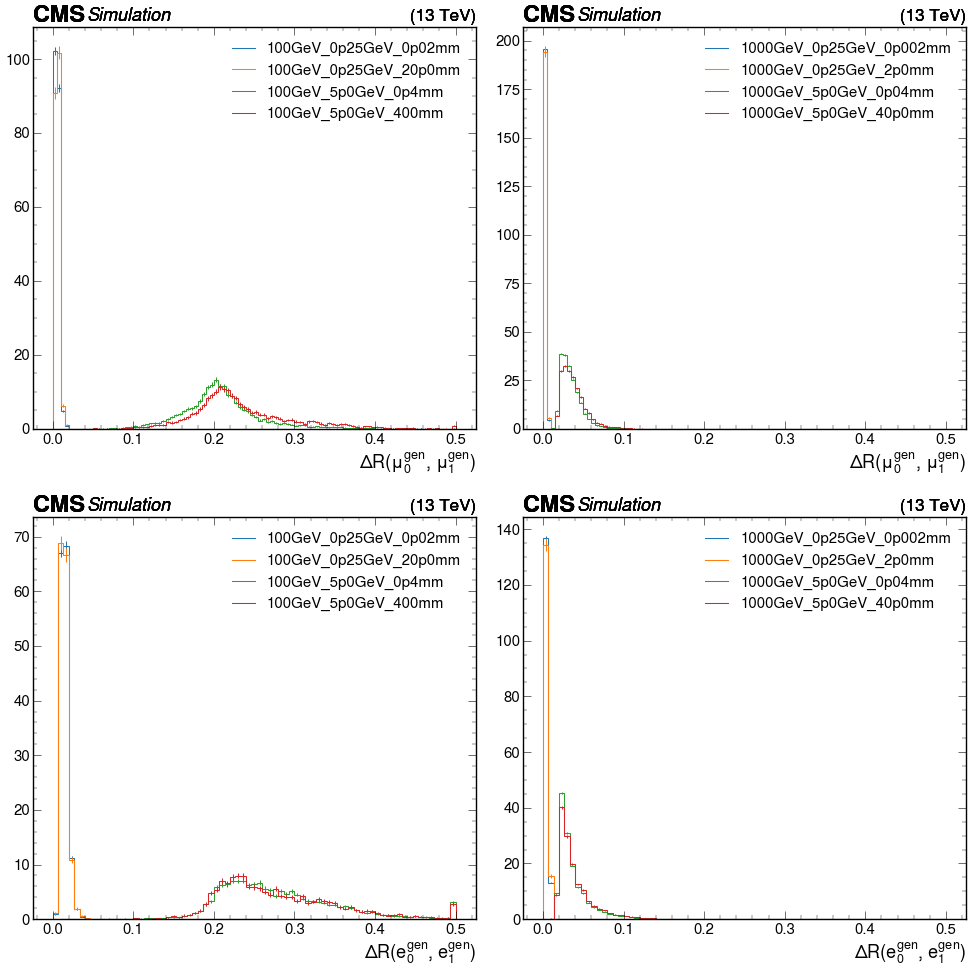

In [7]:
samples_100GeV = [s for s in edge_samples if "100GeV" in s]
samples_1000GeV = [s for s in edge_samples if "1000GeV" in s]

plt.subplots(2, 2, figsize=(20, 20))
plt.subplot(2, 2, 1)
plot_all_samples(samples_100GeV, "genMu_genMu_dR_lowRange")
plt.subplot(2, 2, 2)
plot_all_samples(samples_1000GeV, "genMu_genMu_dR_lowRange")
plt.subplot(2, 2, 3)
plot_all_samples(samples_100GeV, "genE_genE_dR_lowRange")
plt.subplot(2, 2, 4)
plot_all_samples(samples_1000GeV, "genE_genE_dR_lowRange")
plt.tight_layout()

Great, I think this shows that ctau is irrelevant to gen-level e-e and mu-mu dR, which makes sense. On the other hand, I don't understand the shape difference between electrons and photons. The electron distribution is basically the same as we observed with the ffntuples. I'll set this mystery aside for the moment.

Next, take a look as a function of bound state and dark photon mass while holding dark photon decay length constant (choose 30cm ctau points).

### Look at full bound state mass vs dark photon mass plane

In [8]:
# ctau for Lxy = 30cm
mass_plane_samples = [
    "2Mu2E_100GeV_0p25GeV_2p0mm",
    "2Mu2E_100GeV_1p2GeV_9p6mm",
    "2Mu2E_100GeV_5p0GeV_40p0mm",
    "2Mu2E_150GeV_0p25GeV_1p3mm",
    "2Mu2E_150GeV_1p2GeV_6p4mm",
    "2Mu2E_150GeV_5p0GeV_27p0mm",
    "2Mu2E_200GeV_0p25GeV_1p0mm",
    "2Mu2E_200GeV_1p2GeV_4p8mm",
    "2Mu2E_200GeV_5p0GeV_20p0mm",
    "2Mu2E_500GeV_0p25GeV_0p4mm",
    "2Mu2E_500GeV_1p2GeV_1p9mm",
    "2Mu2E_500GeV_5p0GeV_8p0mm",
    "2Mu2E_800GeV_0p25GeV_0p25mm",
    "2Mu2E_800GeV_1p2GeV_1p2mm",
    "2Mu2E_800GeV_5p0GeV_5p0mm",
    "2Mu2E_1000GeV_0p25GeV_0p2mm",
    "2Mu2E_1000GeV_1p2GeV_0p96mm",
    "2Mu2E_1000GeV_5p0GeV_4p0mm",
]
fileset = utilities.make_fileset(mass_plane_samples, "llpNanoAOD_v2", max_files=-1, location_cfg="signal_2mu2e_v10.yaml")

channels = ["baseNoLj"]
p = sidm_processor.SidmProcessor(
    channels,
    ["genE_base", "genMu_base"],
)

output = runner.run(fileset, treename="Events", processor_instance=p)
out = output["out"]

First group samples by bound state mass

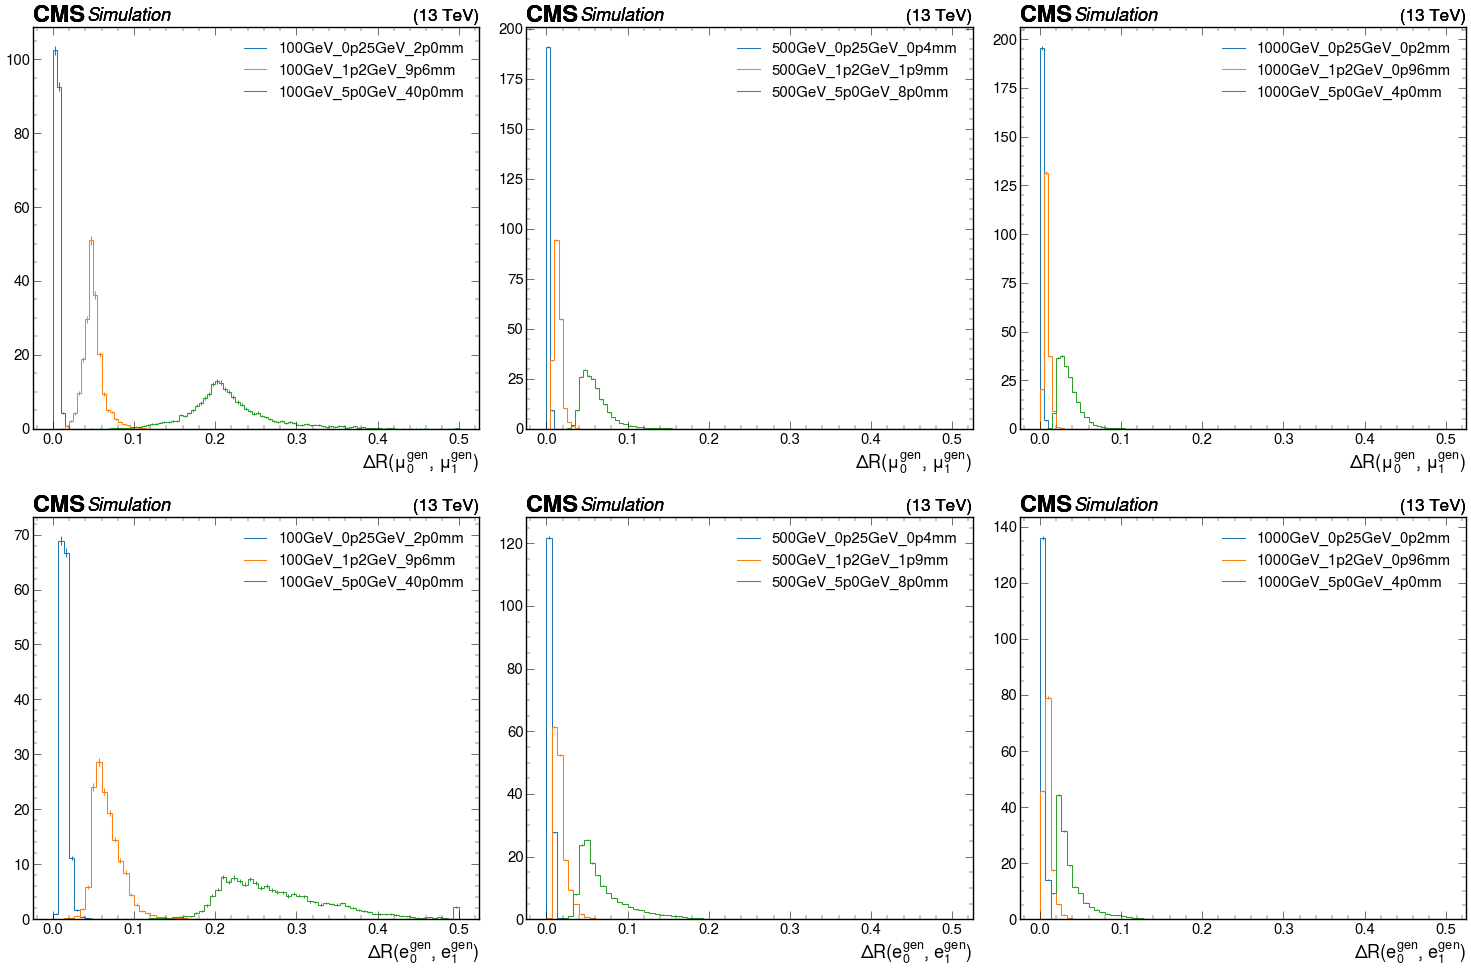

In [9]:
samples_100GeV = [s for s in mass_plane_samples if "100GeV" in s]
samples_500GeV = [s for s in mass_plane_samples if "500GeV" in s]
samples_1000GeV = [s for s in mass_plane_samples if "1000GeV" in s]

plt.subplots(2, 3, figsize=(30, 20))
plt.subplot(2, 3, 1)
plot_all_samples(samples_100GeV, "genMu_genMu_dR_lowRange")
plt.subplot(2, 3, 2)
plot_all_samples(samples_500GeV, "genMu_genMu_dR_lowRange")
plt.subplot(2, 3, 3)
plot_all_samples(samples_1000GeV, "genMu_genMu_dR_lowRange")
plt.subplot(2, 3, 4)
plot_all_samples(samples_100GeV, "genE_genE_dR_lowRange")
plt.subplot(2, 3, 5)
plot_all_samples(samples_500GeV, "genE_genE_dR_lowRange")
plt.subplot(2, 3, 6)
plot_all_samples(samples_1000GeV, "genE_genE_dR_lowRange")
plt.tight_layout()

Next group samples by dark photon mass and include all bound state masses

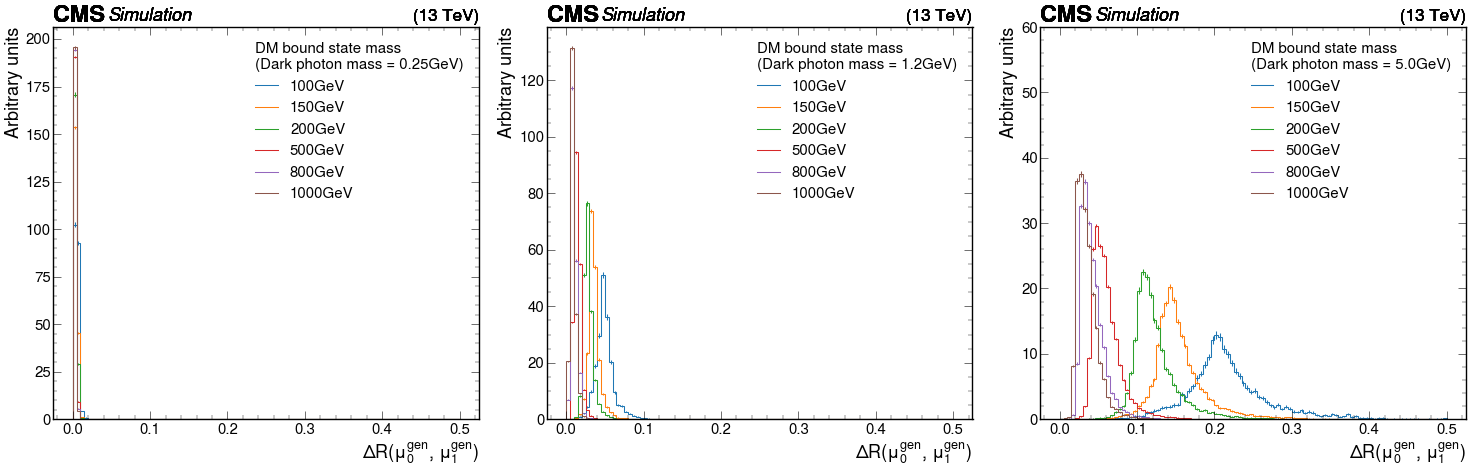

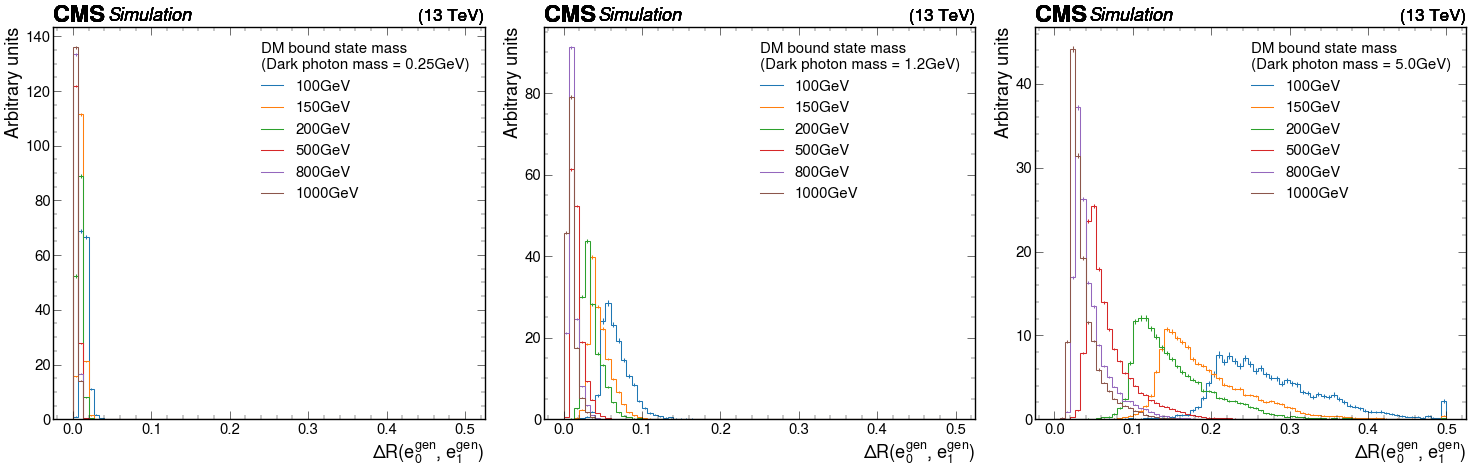

In [10]:
def plot_vs_bs_mass(samples, hist):
    for sample in samples:
        utilities.plot(out[sample]["hists"][hist][channels[0], :], density=True)
    dp_mass = samples[0].split("_")[2].replace("p", ".")
    plt.legend([s.split("_")[1] for s in samples], title=f"DM bound state mass\n(Dark photon mass = {dp_mass})", alignment="left", title_fontsize="small")
    plt.ylabel("Arbitrary units")

samples_0p25GeV = [s for s in mass_plane_samples if "_0p25GeV" in s]
samples_1p2GeV = [s for s in mass_plane_samples if "_1p2GeV" in s]
samples_5GeV = [s for s in mass_plane_samples if "_5p0GeV" in s]

plt.subplots(1, 3, figsize=(30, 10))
plt.subplot(1, 3, 1)
plot_vs_bs_mass(samples_0p25GeV, "genMu_genMu_dR_lowRange")
plt.subplot(1, 3, 2)
plot_vs_bs_mass(samples_1p2GeV, "genMu_genMu_dR_lowRange")
plt.subplot(1, 3, 3)
plot_vs_bs_mass(samples_5GeV, "genMu_genMu_dR_lowRange")
plt.ylim(0, 60)
plt.tight_layout()
plt.savefig(f"{sidm_path}/plots/gen_muon_dR.pdf", bbox_inches="tight")

plt.subplots(1, 3, figsize=(30, 10))
plt.subplot(1, 3, 1)
plot_vs_bs_mass(samples_0p25GeV, "genE_genE_dR_lowRange")
plt.subplot(1, 3, 2)
plot_vs_bs_mass(samples_1p2GeV, "genE_genE_dR_lowRange")
plt.subplot(1, 3, 3)
plot_vs_bs_mass(samples_5GeV, "genE_genE_dR_lowRange")
plt.tight_layout()
plt.savefig(f"{sidm_path}/plots/gen_electron_dR.pdf", bbox_inches="tight")

Cool, I think this gives a pretty reasonable overall picture of the behavior. I had initially assumed that the bound state mass would really be the dominant factor, but dark photon mass matters more than I expected. I also conclude that most of the parameter space considered here would be covered by LJs with radii less than about 0.1. Choosing dR=0.1 would only miss dark photons 5GeV dark photons for bound state masses less than a few hundred GeV. We should keep this in mind once we start taking a look at background levels.

It would be nice to plot the average (or some such statistic) dR for the full bound state mass vs dark photon mass plane. I'll give this a try real quick.

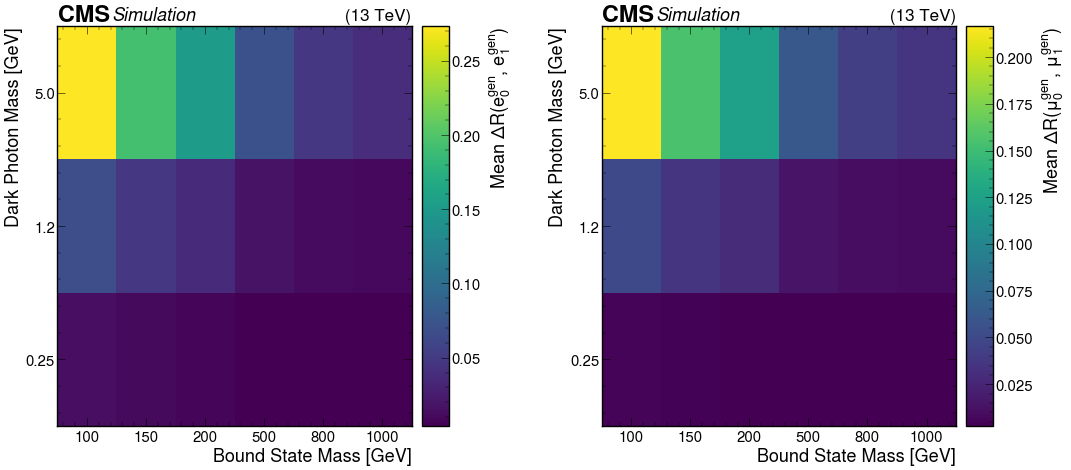

In [11]:
def get_bs_mass(sample):
    return sample.split("_")[1].strip("GeV")

def get_dp_mass(sample):
    return sample.split("_")[2].strip("GeV").replace("p", ".")

bs_masses = list(dict.fromkeys([get_bs_mass(s) for s in mass_plane_samples]))
dp_masses = list(dict.fromkeys([get_dp_mass(s) for s in mass_plane_samples]))

from hist import Hist
h_mu = (
    Hist.new.StrCategory(bs_masses, name="bs_mass", label="Bound State Mass [GeV]")
    .StrCategory(dp_masses, name="dp_mass", label="Dark Photon Mass [GeV]")
    .Double()
)
h_e = (
    Hist.new.StrCategory(bs_masses, name="bs_mass", label="Bound State Mass [GeV]")
    .StrCategory(dp_masses, name="dp_mass", label="Dark Photon Mass [GeV]")
    .Double()
)

for sample in mass_plane_samples:
    mass_bs = get_bs_mass(sample)
    mass_dp = get_dp_mass(sample)
    mu_dR_mean = utilities.get_hist_mean(out[sample]["hists"]["genMu_genMu_dR_lowRange"][channels[0], :])
    e_dR_mean = utilities.get_hist_mean(out[sample]["hists"]["genE_genE_dR_lowRange"][channels[0], :])
    h_mu.fill(mass_bs, mass_dp, weight=mu_dR_mean)
    h_e.fill(mass_bs, mass_dp, weight=e_dR_mean)

plt.subplots(1, 2, figsize=(22, 10))

plt.subplot(1, 2, 2)
utilities.plot(h_mu, flow="none")
cb = plt.gca().collections[-1].colorbar
cb.ax.set_ylabel("Mean $\Delta R$($\mu_0^{gen}$, $\mu_1^{gen}$)", labelpad=10)

plt.subplot(1, 2, 1)
utilities.plot(h_e, flow="none")
cb = plt.gca().collections[-1].colorbar
cb.ax.set_ylabel("Mean $\Delta R$($e_0^{gen}$, $e_1^{gen}$)", labelpad=10)

plt.tight_layout(w_pad=2)
plt.savefig(f"{sidm_path}/plots/gen_lepton_mean_dR.pdf", bbox_inches="tight")

Nice, this works and the result appears to match the earlier 1D plots. It would be good to store the signal parameters as fields so that we can automatically generate this kind of plot in the future. If we assume the reco-level distributions don't vary too much from these gen-level results, then I think the main takeaways are:
- LJ dR = 0.4 captures effectively our entire signal grid
- LJ dR = 0.2 would harm our <=200GeV bound state mass signal efficiency for 5GeV dark photons (effectively killing off 100GeV), but would otherwise be totally fine
- LJ dR = 0.1 would effectively kill off <=200GeV bound state mass signal efficiency for 5GeV dark photons and start to cut into 200--500GeV a bit
- Most of our parameter space is dominated by leptons with dR<0.1 (frequently near dR=0.01)

I think the next important step is to take a look at how this maps to reco-level dR.
